In [1]:
using JLD2
using FourierFlows
using FourierFlows: parsevalsum2
using Printf
using CairoMakie
using AbstractFFTs
include("../../thomasyamada/TYUtils.jl")
include("../../thomasyamada/ThomasYamada.jl")
include("../../utils/IFMAB3.jl")
include("../../rsw/RotatingShallowWater.jl")
include("../../rsw/RSWUtils.jl")
using .RotatingShallowWater
using .ThomasYamada
using .TYUtils: decompose_balanced_wave, compute_balanced_basis, compute_wave_bases

### Define some windowing functions for Fourier time analysis

In [2]:
function hann(L)
    ell = L + 1
    n = 0:(ell - 1)
    #w = @. 0.5 * (1 - cos.(2*π*n/ell))
    w = @. sin(π * n / ell)^2
    return w[1:end-1]
end

function hamm(L)
    ell = L + 1
    N = ell - 1
    n = 0:N
    w = @. 0.54 - 0.46 * cos.(2*π*n/N)
    return w[1:end-1]
end
function box(L)
    w = ones(L)
    return w
end

function tukey(L, r)
    x = (0:(L-1)) / (L-1)
    w = ones(L)
    filter1 = @. (0 <= x < r/2)
    filter2 = @. (1 - r/2 <= x <= 1)

    w[filter1] = @. 0.5 * (1 + cos(2*π/r*(x[filter1] - r/2)))
    w[filter2] = @. 0.5 * (1 + cos(2*π/r*(x[filter2]-1+r/2)))
    return w
end

function triangle(L)
    ell = L+1
    w = zeros(ell)
    if ell % 2 == 0
        ell_half = Int(ell/2)
        n1 = 1:ell_half
        n2 = (ell_half+1):ell
        w[n1] = @. (2 * n1 - 1)/ell
        w[n2] = @. 2 - (2 * n2 - 1)/ell
    else
        ell_half = Int((ell+1)/2)
        n1 = 1:ell_half
        n2 = (ell_half+1):ell
        w[n1] = @. (2 * n1)/ell
        w[n2] = @. 2 - (2 * n2)/ell
    end
    return w[1:end-1]
end

function flattopw(L)
    a0 = 0.21557895
    a1 = 0.41663158
    a2 = 0.277263158
    a3 = 0.083578947
    a4 = 0.006947368
    ell = L+1
    n = 0:(ell - 1)
    w = @. (a0 - a1*cos(2*π*n/(ell - 1))
              + a2*cos(4*π*n/(ell - 1))
              - a3*cos(6*π*n/(ell - 1))
              + a4*cos(8*π*n/(ell - 1)))
    return w[1:end-1]
end

flattopw (generic function with 1 method)

#### Define the files we need

In [4]:
# These files are for the low-wave case where we initalize max p_W = 0.0 and max p_C = 0.3 and Ro=1.0
#main_file_directory = "/scratch/nad9961/thomasyamada_simulation/50352267"
#spinup_file_directory = "/vast/nad9961/thomasyamada_simulation/50225982"

# p_W = 0.0, p_C = 0.3, Ro=0.25
#main_file_directory = "/vast/nad9961/thomasyamada_simulation/50459728"
#spinup_file_directory = "/vast/nad9961/thomasyamada_simulation/50459728"

# p_W = 0.1, p_C = 0.3, Ro=0.25
#main_file_directory = "/vast/nad9961/thomasyamada_simulation/50459731"
#spinup_file_directory = "/vast/nad9961/thomasyamada_simulation/50459731"

# Rotating Shallow Water directories
#spinup_file_directory = "/scratch/nad9961/rsw/51962610/11"
#main_file_directory = "/scratch/nad9961/rsw/51962610/11"

# Rotating shallow water used to get current images as of 4/30/2025
#run_idx = 7
#spinup_file_directory = "/scratch/nad9961/rsw/53528052/" * string(run_idx)
#main_file_directory = "/scratch/nad9961/rsw/53528052/" * string(run_idx)

# 2048 x 2048 domain size
run_idx = 1
spinup_file_directory = "/vast/nad9961/rsw/59916630/" * string(run_idx)
main_file_directory = "/vast/nad9961/rsw/59916630/" * string(run_idx)

#main_file_directory = "/vast/nad9961/thomasyamada_simulation/51333202"
#spinup_file_directory = "/vast/nad9961/thomasyamada_simulation/51333202"

#startup_diagnostics = jldopen(@sprintf("%s/startup_diagnostics.jld2", spinup_file_directory))
#startup_snapshot    = jldopen(@sprintf("%s/startup.jld2"            , spinup_file_directory))
startup_snapshot    = jldopen(@sprintf("%s/rsw.000000.jld2"   , spinup_file_directory))
main_config         = jldopen(@sprintf("%s/rsw.000000.jld2"   , main_file_directory))
main_diagnostics    = jldopen(@sprintf("%s/diagnostics.jld2"        , main_file_directory))
#main_diagnostics    = jldopen(@sprintf("%s/diagnostic_file.jld2"        , main_file_directory))
#last_file           = jldopen(@sprintf("%s/ty.000003.jld2"   , main_file_directory))
last_file           = jldopen(@sprintf("%s/rsw.000033.jld2"   , main_file_directory))
last_snapshot = keys(last_file["snapshots/t"])[end]

# Define grid
#nx = startup_snapshot["grid/nx"]
#Lx = startup_snapshot["grid/Lx"]
nx = 2048
Lx = 2π
grid = TwoDGrid(; nx, Lx)

TwoDimensionalGrid
  ├───────────────── Device: CPU
  ├────────────── FloatType: Float64
  ├────────── size (Lx, Ly): (6.283185307179586, 6.283185307179586)
  ├──── resolution (nx, ny): (2048, 2048)
  ├── grid spacing (dx, dy): (0.0030679615757712823, 0.0030679615757712823)
  ├───────────────── domain: x ∈ [-3.141592653589793, 3.1385246920140215]
  |                          y ∈ [-3.141592653589793, 3.1385246920140215]
  └─ aliased fraction: 0.3333333333333333

In [15]:
function isospectrum(fh, grid)
    nmax = (Int(min(grid.nk, grid.nl)/2) - 1)
    ρ = ((0:nmax+1)) / min(grid.Lx, grid.Ly) * (2*pi)
    Fρ = zeros(nmax+2,1)
    K = nothing
    scaling = nothing
    if size(fh, 1) == grid.nkr
        K = sqrt.(grid.Krsq)
        scaling = ones(size(grid.Krsq)) * grid.dx * grid.dy / grid.nx / grid.ny
        scaling[2:grid.nkr-1,:] .*= 2.
    else
        K = sqrt.(grid.Ksq)
        scaling = ones(size(grid.Ksq)) * grid.dx * grid.dy / grid.nx / grid.ny
    end
    for i=2:nmax+2
        mask = @. (ρ[i-1] < K) & (K <= ρ[i])
        Fρ[i] = sum(fh .* mask .* scaling) 
    end
    return ρ[2:end], Fρ[2:end]
end

function component_energy(snapshot, grid)
    Gh, Wh = decompose_balanced_wave(snapshot, grid)
    geo_energy  = abs2.(Gh[:,:,1]) + abs2.(Gh[:,:,2]) + abs2.(Gh[:,:,3])
    wave_energy = abs2.(Wh[:,:,1]) + abs2.(Wh[:,:,2]) + abs2.(Wh[:,:,3])
    baroT_energy = abs2.(sqrt.(grid.invKrsq) .* snapshot[:,:,1])
    
    _, geo_radial_energy   = isospectrum(geo_energy  , grid)
    _, wave_radial_energy  = isospectrum(wave_energy , grid)
    ρ, baroT_radial_energy = isospectrum(baroT_energy, grid)

    return (ρ, baroT_radial_energy, geo_radial_energy, wave_radial_energy)
end

function wave_geostrophic_energy(snapshot, grid, f, Cg2)
    ((ugh, vgh, ηgh), (uwh, vwh, ηwh)) = wave_balanced_decomposition(snapshot[:, :, 1], snapshot[:, :, 2], snapshot[:, :, 3], grid, (f = f, Cg2=Cg2))

    u = irfft(ugh, grid.nx)
    v = irfft(vgh, grid.nx)
    η = irfft(ηgh, grid.nx)
    KE = sqrt.(0.5 * @. (1 + η) * (u^2 + v^2))
    PE = 0.5 * @. (1 + η)^2
    KEh = rfft(KE)
    PEh = rfft(PE)
    geo_energy  = abs2.(ugh) + abs2.(vgh)# + abs.(PEh)

    u = irfft(uwh, grid.nx)
    v = irfft(vwh, grid.nx)
    η = irfft(ηwh, grid.nx)
    KE = sqrt.(0.5 * @. (1 + η) * (u^2 + v^2))
    PE = 0.5 * @. (1 + η)^2
    KEh = rfft(KE)
    PEh = rfft(PE)
    
    wave_energy = abs2.(uwh) + abs2.(vwh)# + abs2.(PEh)# + abs2.(ηwh)

    ρ, geo_radial_energy = isospectrum(geo_energy, grid)
    ρ, wave_radial_energy = isospectrum(wave_energy, grid)
    return (ρ, geo_radial_energy, wave_radial_energy)
end

function create_rsw_figure(snapshot, grid, ax, Kd, f, Cg2)
    ρ, geo_E, wave_E = wave_geostrophic_energy(snapshot, grid, f, Cg2)
    
    lines!(ax, ρ/Kd, replace!(geo_E[:]  , 0.0=>eps(0.0)), label="Geostrophic components", linewidth=3, color="red")
    lines!(ax, ρ/Kd, replace!(wave_E[:] , 0.0=>eps(0.0)), label="Wave components", linewidth=3, color="black")
    
end

function create_rsw_linear_omega_figure(snapshot, grid, ax, Kd, f, Cg2)
    K, geo_E, wave_E = wave_geostrophic_energy(snapshot, grid, f, Cg2)
    ω = @. sqrt(f^2 + Cg2 * K^2)
    jacobian_factor = @. ω / (Cg2 * K)
    lines!(ax, ω/f, replace!(wave_E[:] .* jacobian_factor , 0.0=>eps(0.0)), label="Wave components", linewidth=3, color="black")
    
end

function create_energy_figure(snapshot, grid, ax, Kd)
    ρ, baroT_E, geo_E, wave_E = component_energy(snapshot, grid)
    
    lines!(ax, ρ/Kd, replace!(geo_E[:]  , 0.0=>eps(0.0)), label="Baroclinic geostrophic components", linewidth=3, color="red")
    lines!(ax, ρ/Kd, replace!(baroT_E[:], 0.0=>eps(0.0)), label="Barotropic components", linewidth=3, color="blue")
    lines!(ax, ρ/Kd, replace!(wave_E[:] , 0.0=>eps(0.0)), label="Baroclinic wave components", linewidth=3, color="brown")
    
end

create_energy_figure (generic function with 1 method)

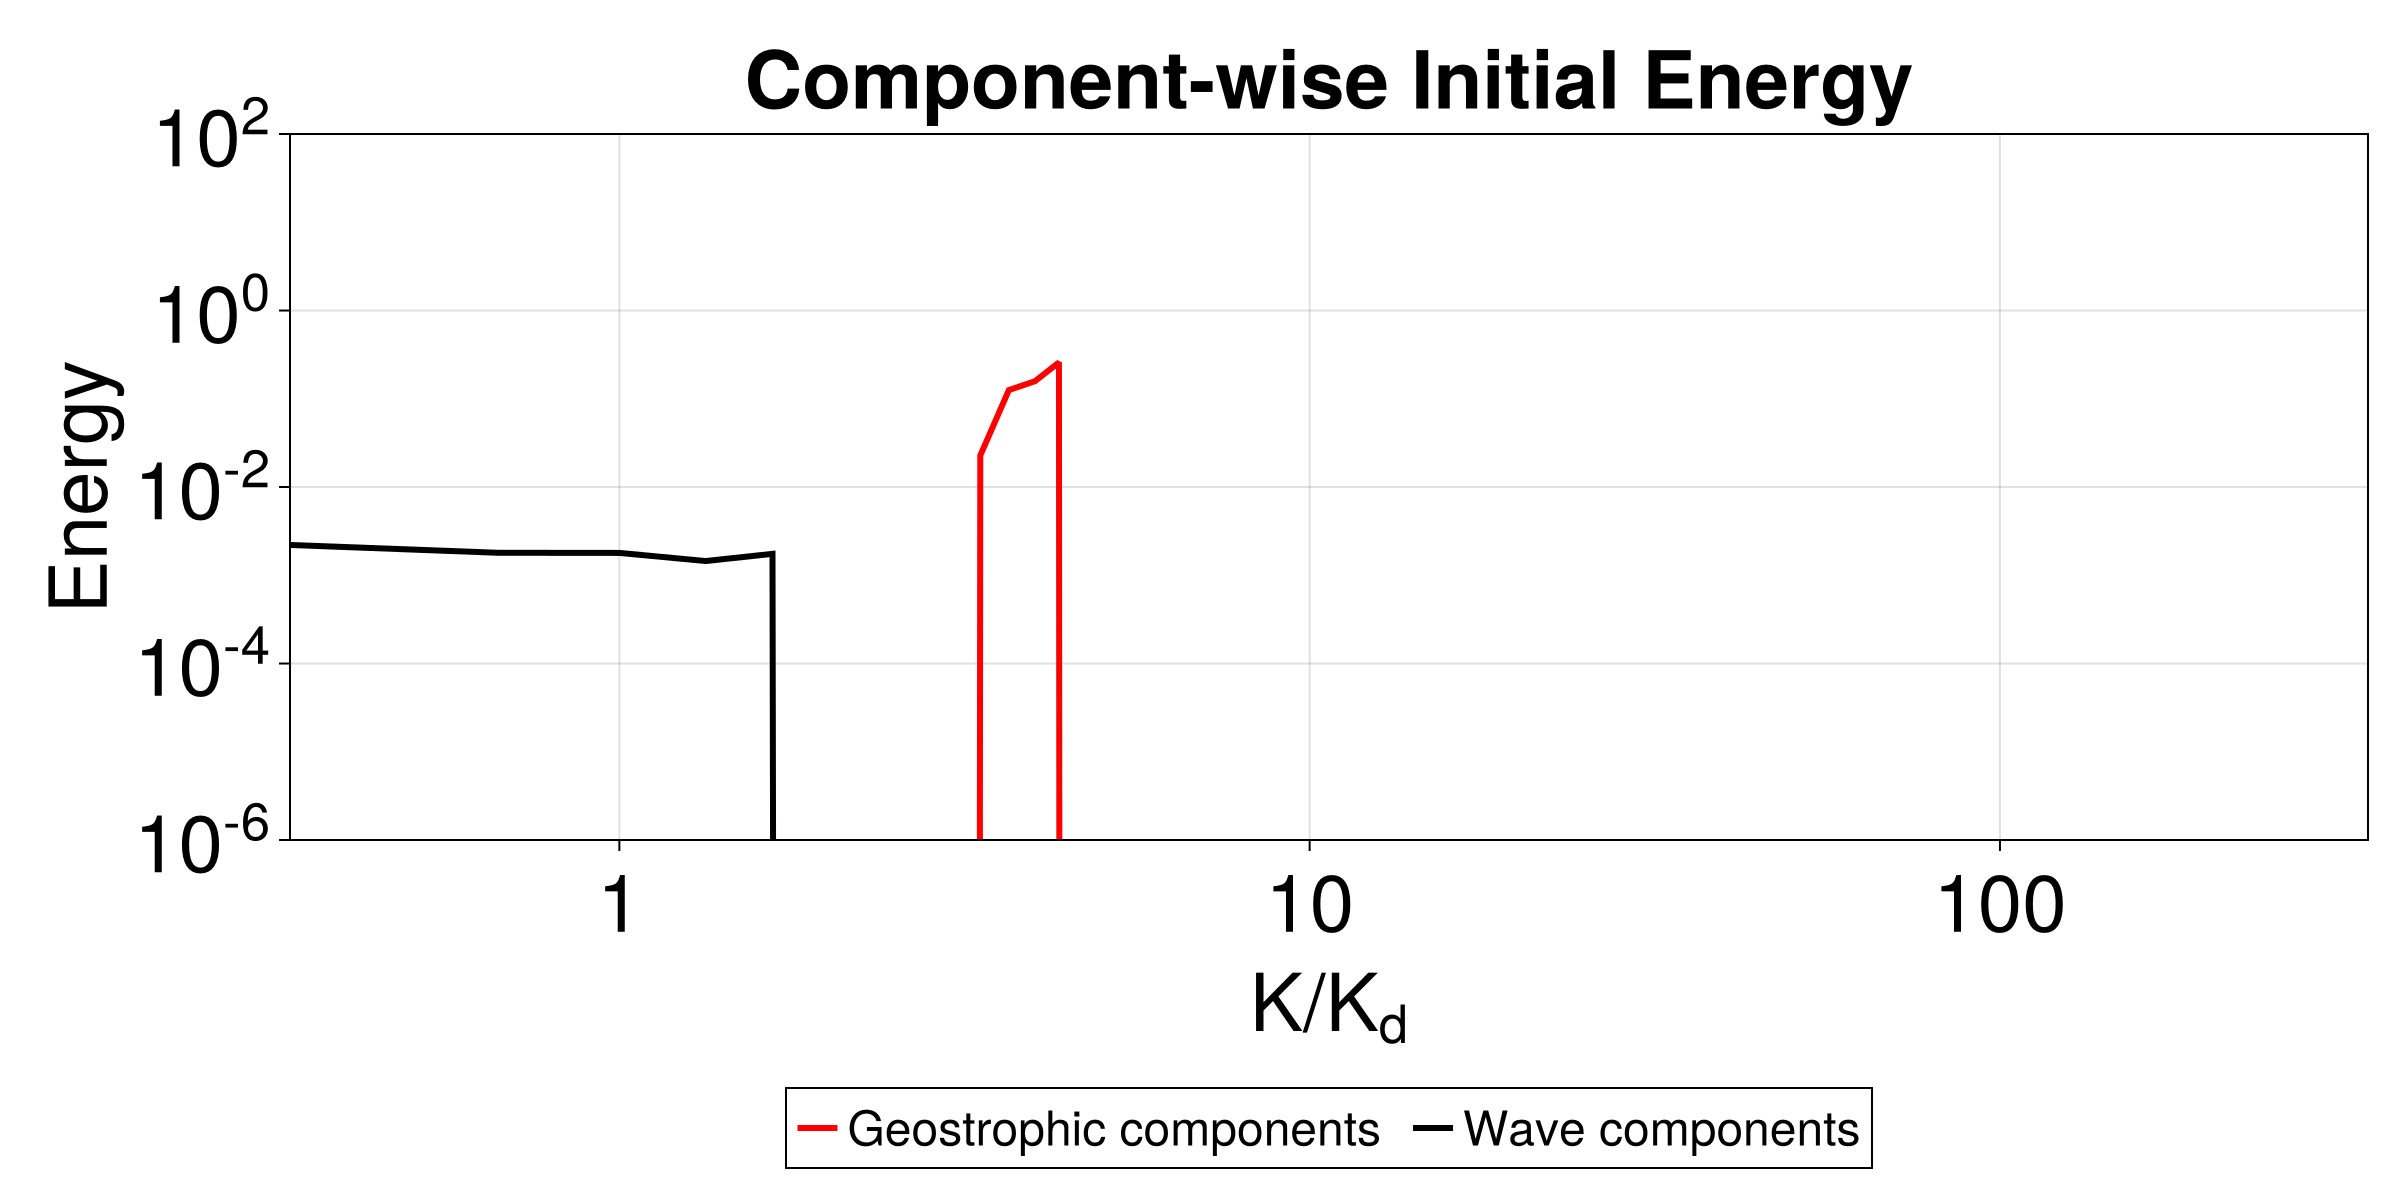

In [6]:
ic_snapshot = startup_snapshot["snapshots/sol/0"]
f0 = startup_snapshot["params/f"]
Cg2 = startup_snapshot["params/Cg2"]

ρ, _, _ = wave_geostrophic_energy(ic_snapshot, grid, f0, Cg2)
Kd = 3

f = Figure(size=(1200, 600), fontsize=40)
ax = Axis(f[1,1], title="Component-wise Initial Energy", xscale=log10, yscale=log10, 
        xlabel=rich("K/K", subscript("d")), ylabel="Energy",
        limits=((ρ[1]/Kd, ρ[end]/Kd), (1e-6, 1e2)),
        xticks=[1, 10, 100], yticks=[1e-6, 1e-4, 1e-2, 1, 1e2],
        ytickformat = values -> [rich("10", superscript(string(round(Int, value)))) for value in log10.(values)])

create_rsw_figure(ic_snapshot, grid, ax, Kd, f0, Cg2)
f[2, 1] = Legend(f, ax, labelsize=24, orientation = :horizontal)

f

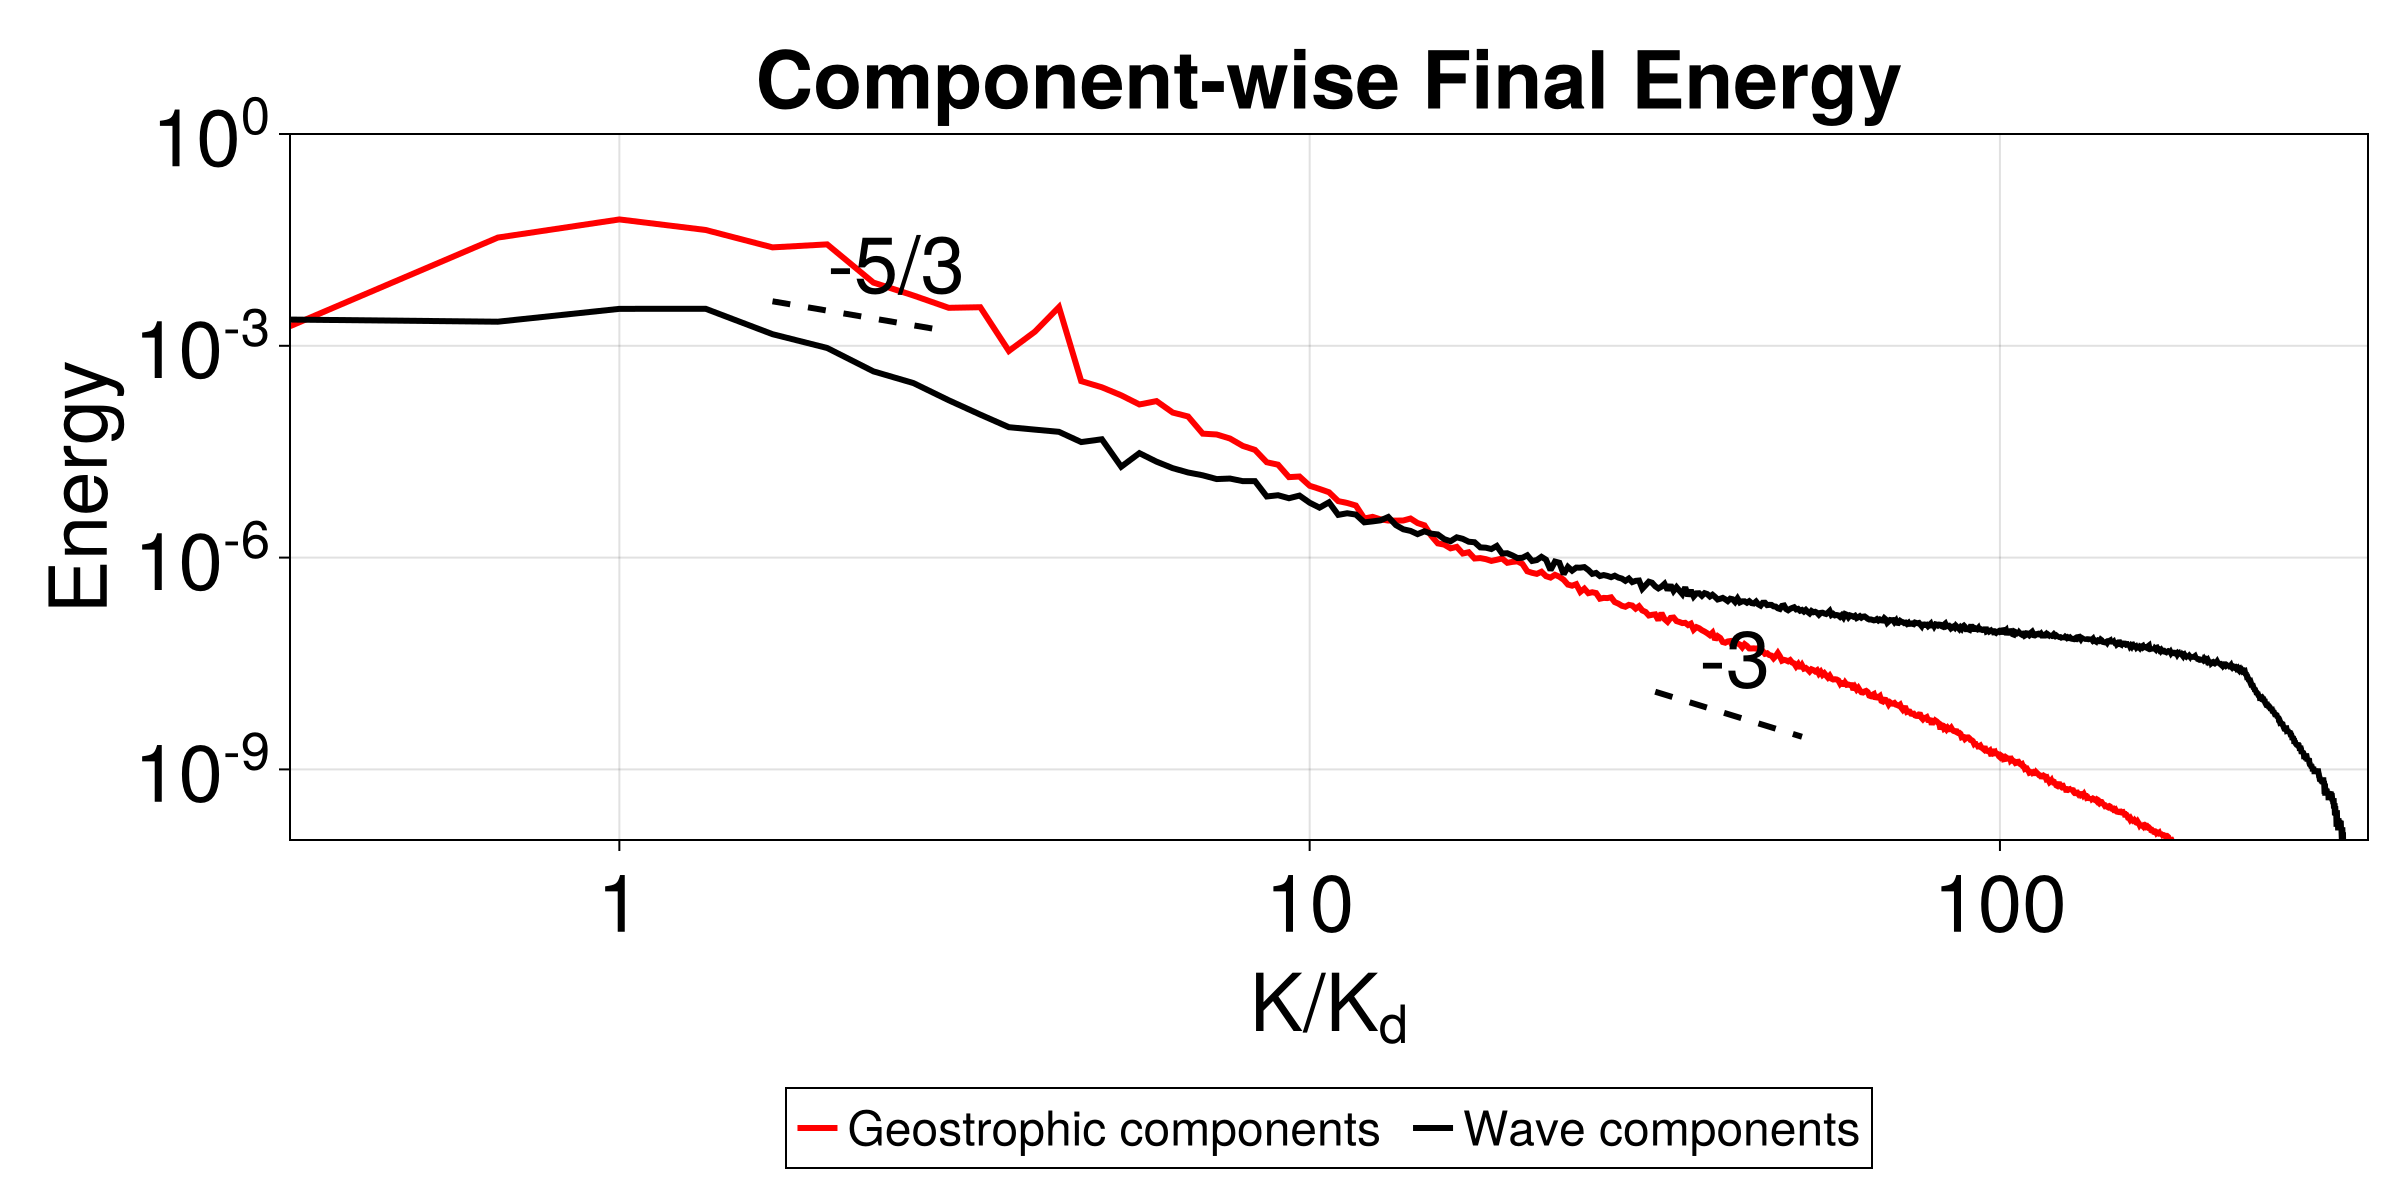

In [7]:
final_snapshot = last_file["snapshots/sol/" * last_snapshot]
begin_snapshot = main_config["snapshots/sol/0"]

ρ, _, _ = wave_geostrophic_energy(final_snapshot, grid, f0, Cg2)
Kd = 3

f = Figure(size=(1200, 600), fontsize=40)
ax = Axis(f[1,1], title="Component-wise Final Energy", xscale=log10, yscale=log10, 
        xlabel=rich("K/K", subscript("d")), ylabel="Energy",
        limits=((ρ[1]/Kd, ρ[end]/Kd), (1e-10, 1e0)),
        xticks=[1, 10, 100], yticks=[1e-12, 1e-9, 1e-6, 1e-3, 1],
        ytickformat = values -> [rich("10", superscript(string(round(Int, value)))) for value in log10.(values)])

#create_energy_figure(begin_snapshot, grid, ax, Kd)
create_rsw_figure(final_snapshot, grid, ax, Kd, f0, Cg2)
f[2, 1] = Legend(f, ax, labelsize=24, orientation = :horizontal)

ω_trend = (ρ[1]:ρ[end])/Kd

lines!(ax, ω_trend[95:155], 4e-4*ω_trend[95:155].^(-3.00), linestyle=:dash, color=:black, linewidth=3)
text!( ax, ω_trend[110], 4e-4*ω_trend[110]^(-3.00), text="-3")

lines!(ax, ω_trend[5:9], 1e-2*ω_trend[5:9].^(-5/3.), linestyle=:dash, color=:black, linewidth=3)
text!( ax, ω_trend[6], 1e-2*ω_trend[6]^(-5/3.), text="-5/3")

#lines!(ax, ω_trend[55:155], 1e-3*ω_trend[55:155].^(-2.), linestyle=:dash, color=:black, linewidth=3)
#text!( ax, ω_trend[110], 1e-3*ω_trend[110]^(-2.), text="-2")
f

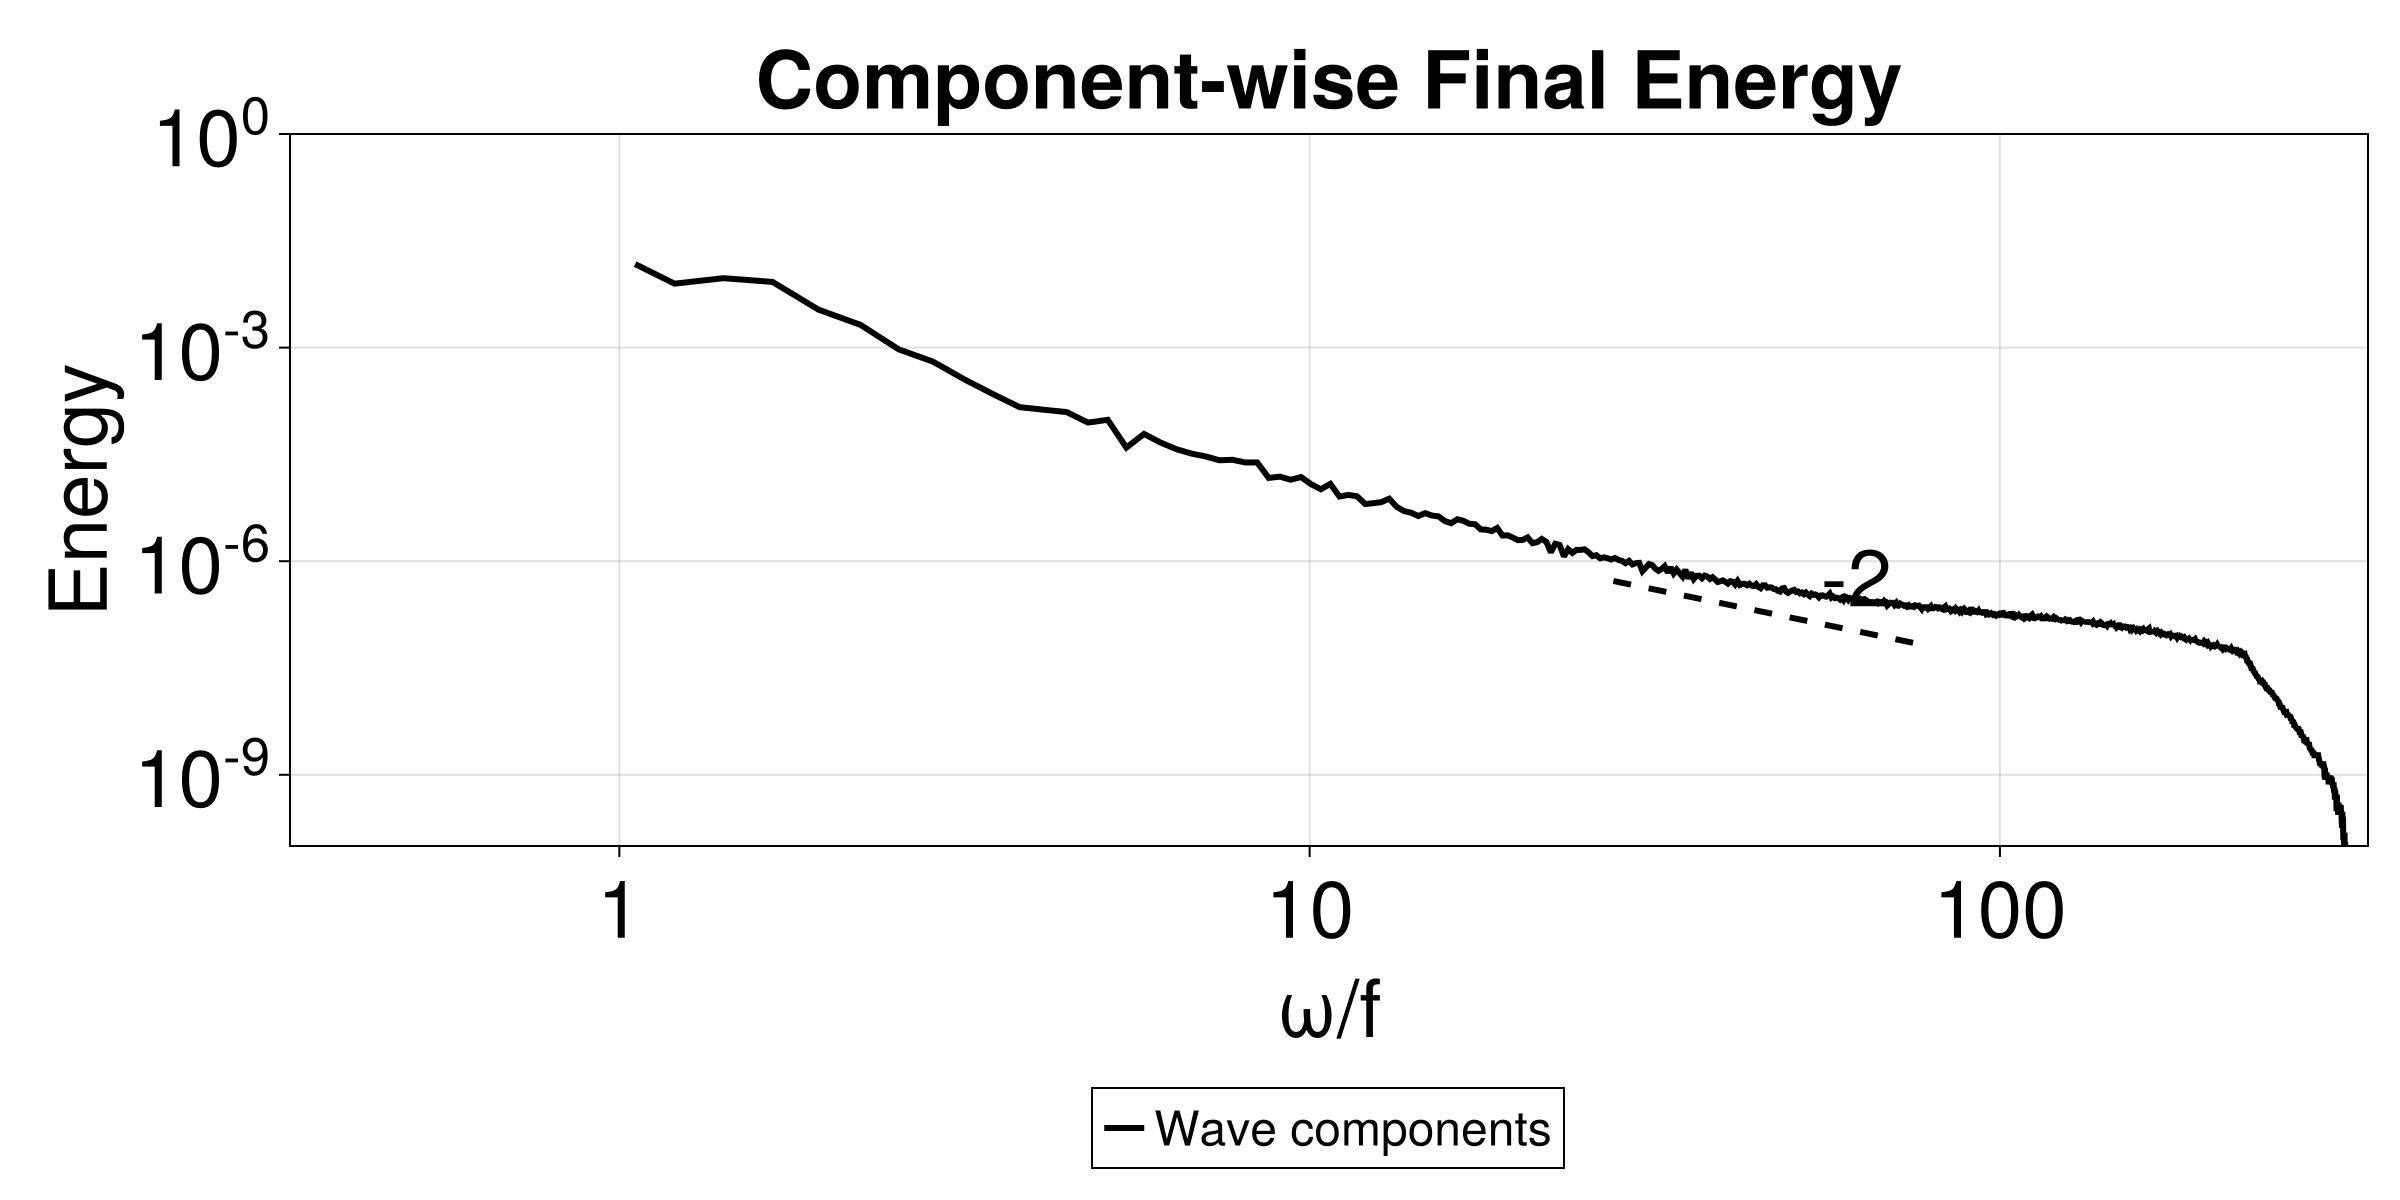

In [18]:
final_snapshot = last_file["snapshots/sol/" * last_snapshot]
begin_snapshot = main_config["snapshots/sol/0"]

ρ, _, _ = wave_geostrophic_energy(final_snapshot, grid, f0, Cg2)
Kd = 3

f = Figure(size=(1200, 600), fontsize=40)
ax = Axis(f[1,1], title="Component-wise Final Energy", xscale=log10, yscale=log10, 
        xlabel=rich("ω/f"), ylabel="Energy",
        limits=((ρ[1]/Kd, ρ[end]/Kd), (1e-10, 1e0)),
        xticks=[1, 10, 100], yticks=[1e-12, 1e-9, 1e-6, 1e-3, 1],
        ytickformat = values -> [rich("10", superscript(string(round(Int, value)))) for value in log10.(values)])

#create_energy_figure(begin_snapshot, grid, ax, Kd)
create_rsw_linear_omega_figure(final_snapshot, grid, ax, Kd, f0, Cg2)
f[2, 1] = Legend(f, ax, labelsize=24, orientation = :horizontal)

ω_trend = @. sqrt(f0^2 + Cg2*ρ^2)

lines!(ax, ω_trend[55:155], 4e-4*ω_trend[55:155].^(-2.00), linestyle=:dash, color=:black, linewidth=3)
text!( ax, ω_trend[110], 4e-4*ω_trend[110]^(-2.00), text="-2")

#lines!(ax, ω_trend[55:155], 1e-3*ω_trend[55:155].^(-2.), linestyle=:dash, color=:black, linewidth=3)
#text!( ax, ω_trend[110], 1e-3*ω_trend[110]^(-2.), text="-2")
f

In [14]:
main_diagnostics["diagnostics/energy/data"]

282492-element Vector{Tuple{Float64, Float64}}:
 (2043.5159912109375, 586.4839246719639)
 (2043.5447998046875, 586.5109949855396)
 (2043.5125732421875, 586.5430311196251)
 (2043.4609375, 586.5945789732359)
 (2043.378662109375, 586.6767567108764)
 (2043.251220703125, 586.8040662862477)
 (2043.0606689453125, 586.9944373875624)
 (2042.787109375, 587.2678651328024)
 (2042.4091796875, 587.6455311634345)
 (2041.90576171875, 588.1488368474966)
 (2041.25634765625, 588.7982607014274)
 (2040.44189453125, 589.6124794837815)
 (2039.447265625, 590.6072256170592)
 ⋮
 (1147.923095703125, 1206.516669036413)
 (1146.9622802734375, 1207.4772257152072)
 (1145.99853515625, 1208.4406827847415)
 (1145.0323486328125, 1209.4066007918736)
 (1144.06396484375, 1210.374716064718)
 (1143.0938720703125, 1211.3445012595039)
 (1142.1241455078125, 1212.3141106730327)
 (1141.1544189453125, 1213.283632195933)
 (1140.1822509765625, 1214.2555267658026)
 (1139.208740234375, 1215.2287396950996)
 (1138.236328125, 1216.2008979

In [36]:
function compute_diagnostics(directory, file_count)
    grid = TwoDGrid(; nx=512, Lx=6π)
    
    bt_ke = zeros(file_count+1)
    ge_ke = zeros(file_count+1)
    ge_pe = zeros(file_count+1)
    wa_ke = zeros(file_count+1)
    wa_pe = zeros(file_count+1)
    
    te = zeros(file_count+1)
    
    phi_geo = compute_balanced_basis(grid)
    phi_plus, phi_minus = compute_wave_bases(grid)
    decomp_bases = (phi_geo, phi_plus, phi_minus)
    for file_idx=0:file_count
        array_idx = file_idx + 1
        filename = @sprintf("%s/ty.jld2.%08d.jld2", directory, file_idx)
        if(file_idx % 10 == 0)
            println("Reading " * filename)
        end
        file = jldopen(filename)
        snap_idx = keys(file["snapshots/sol"])[1]
        te[array_idx] = file["snapshots/t/" * snap_idx]
        snapshot = file["snapshots/sol/" * snap_idx]
        bt_ke[array_idx] = ThomasYamada.barotropic_energy(snapshot, grid)
        wave_geo_energy  = ThomasYamada.wave_geostrophic_energy(snapshot, grid)
        ge_ke[array_idx] = wave_geo_energy[2][1]
        ge_pe[array_idx] = wave_geo_energy[2][2]
        wa_ke[array_idx] = wave_geo_energy[1][1]
        wa_pe[array_idx] = wave_geo_energy[1][2]
        close(file)
    end
    return (te, (bt_ke, (ge_ke, ge_pe), (wa_ke, wa_pe)))
end

compute_diagnostics (generic function with 1 method)

In [161]:
#run_t, run_diags = compute_diagnostics("/scratch/nad9961/thomasyamada_simulation/50352267", 296);
#run_t = main_diagnostics["diagnostics/barotropic_energy/t"]
#run_diags = (main_diagnostics["diagnostics/barotropic_energy/data"], 
main_diagnostics

JLDFile /scratch/nad9961/rsw/53528052/7/diagnostics.jld2 (read-only)
 └─📂 diagnostics
    └─📂 energy
       ├─🔢 steps
       ├─🔢 t
       └─🔢 data

In [157]:
f = Figure(size=(800, 600), fontsize=18)
ax = Axis(f[1,1], xlabel="t", ylabel="E(t) - E(0)", title="ΔE over time")

t = startup_diagnostics["diagnostics/barotropic_energy/t"]
barotropic_en = startup_diagnostics["diagnostics/barotropic_energy/data"]
wave_ke = [data[1][1] for data in startup_diagnostics["diagnostics/wave_geostrophic_energy/data"]]
wave_pe = [data[1][2] for data in startup_diagnostics["diagnostics/wave_geostrophic_energy/data"]]
wave_T = wave_ke + wave_pe
geo_ke = [data[2][1] for data in startup_diagnostics["diagnostics/wave_geostrophic_energy/data"]]
geo_pe = [data[2][2] for data in startup_diagnostics["diagnostics/wave_geostrophic_energy/data"]]
geo_T = geo_ke + geo_pe
lines!(ax, t, wave_T .- wave_T[1] , label="Wave energy", linewidth=3, color="brown")
lines!(ax, t, barotropic_en .- barotropic_en[1], label="Barotropic energy", linewidth=3, color="blue")
lines!(ax, t, geo_T .- geo_T[1], label="Balanced baroclinic energy", linewidth=3, color="red")
lines!(ax, t, geo_T + wave_T + barotropic_en .- geo_T[1] .- wave_T[1] .- barotropic_en[1], label="Total", linewidth=3, color="gray")

run_t = main_diagnostics["diagnostics/barotropic_energy/t"]
run_barotropic_en = main_diagnostics["diagnostics/barotropic_energy/data"]
run_wave_ke = [data[1][1] for data in main_diagnostics["diagnostics/baroclinic_energy/data"]]
run_wave_pe = [data[1][2] for data in main_diagnostics["diagnostics/baroclinic_energy/data"]]
run_geo_ke = [data[2][1] for data in main_diagnostics["diagnostics/baroclinic_energy/data"]]
run_geo_pe = [data[2][2] for data in main_diagnostics["diagnostics/baroclinic_energy/data"]]
run_geo_T = run_geo_ke + run_geo_pe
run_wave_T = run_wave_ke + run_wave_pe

lines!(ax, run_t, run_barotropic_en .- barotropic_en[1], color="black", linewidth=3)
lines!(ax, run_t, run_geo_T .- geo_T[1], color="black", linewidth=3)
lines!(ax, run_t, run_wave_T .- wave_T[1], color="black", linewidth=3)
lines!(ax, run_t, run_barotropic_en + run_geo_T + run_wave_T .- wave_T[1] .- geo_T[1] .- barotropic_en[1], color="black", linewidth=3)
#lines!(ax,main_file["diagnostics/barotropic_energy/t"], main_file["diagnostics/barotropic_energy/data"] + main_file["diagnostics/baroclinic_energy/data"])

f[2,1] = Legend(f, ax, framevisible=false, orientation = :horizontal)
f

LoadError: UndefVarError: `startup_diagnostics` not defined

In [ ]:
x, y = unzip(startup_file["diagnostics/wave_geostrophic_energy/data"])
x

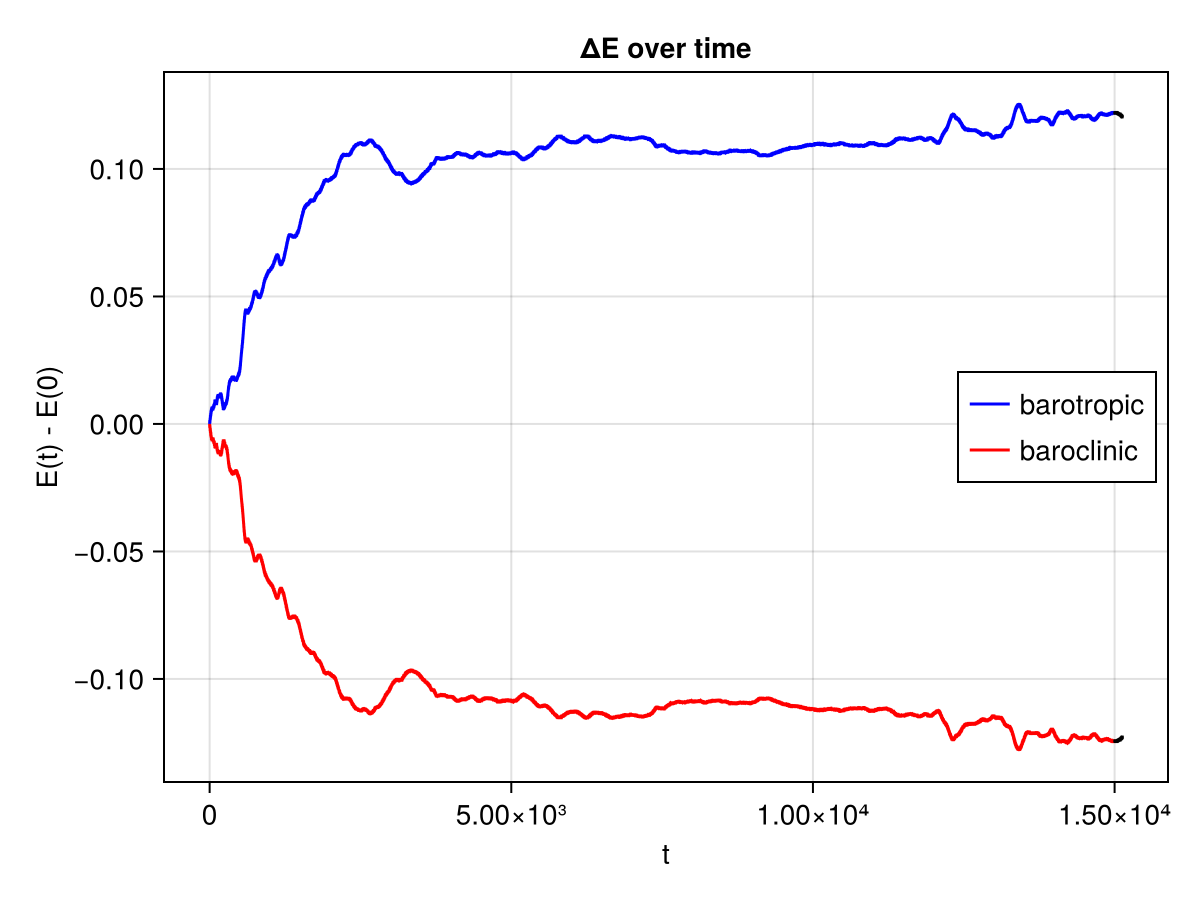

In [15]:
f = Figure()
ax = Axis(f[1,1], xlabel="t", ylabel="E(t) - E(0)", title="ΔE over time")
initial_bt = startup_file["diagnostics/barotropic_energy/data"][1]
initial_bc = startup_file["diagnostics/baroclinic_energy/data"][1]

lines!(ax,startup_file["diagnostics/barotropic_energy/t"], startup_file["diagnostics/barotropic_energy/data"] .- initial_bt, label="barotropic", color="blue")
lines!(ax,startup_file["diagnostics/barotropic_energy/t"], startup_file["diagnostics/baroclinic_energy/data"] .- initial_bc, label="baroclinic", color="red")
lines!(ax,main_file["diagnostics/barotropic_energy/t"], main_file["diagnostics/barotropic_energy/data"] .- initial_bt, color="black")
lines!(ax,main_file["diagnostics/barotropic_energy/t"], main_file["diagnostics/baroclinic_energy/data"] .- initial_bc, color="black")

axislegend(ax, position=:rc)
f

In [50]:
test_file = jldopen("/vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000250.jld2")
T = test_file["snapshots/t/25080"]
dt = test_file["snapshots/t/25080"] - test_file["snapshots/t/25079"]
Rayleigh_ω = 2*π / T
Nyquist_ω = π / dt
println("Rayleigh: ", Rayleigh_ω)
println("Nyquist: ", Nyquist_ω)

Rayleigh: 0.05010274872957968
Nyquist: 628.31853071853


In [4]:
grid = TwoDGrid(; nx=512, Lx=6π)

#first_file = jldopen("/vast/nad9961/thomasyamada_simulation/49115150/ty.jld2.00000000.jld2")
#last_file = jldopen("/vast/nad9961/thomasyamada_simulation/49115150/ty.jld2.00000251.jld2")
test_file = jldopen("/vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000249.jld2")
#snap_file = jldopen("/vast/nad9961/thomasyamada_simulation/49156496/startup.jld2")
snapshot = test_file["snapshots/sol/24999"]
#snapshot = first_file["snapshots/sol/1"]
baroclinic_en = abs2.(snapshot[:,:,2]) + abs2.(snapshot[:,:,3])
k_max = 257
max_radial_K = grid.kr[end] * sqrt(2)
max_effective_radial_K = grid.kr[k_max]
refinement_factor = 2
dk = grid.kr[2] - grid.kr[1]
k_values = (0:(max_radial_K * refinement_factor)) ./ refinement_factor .+ dk/2


radial_data = zeros(ceil(Int, max_radial_K * refinement_factor))
for ki=1:length(grid.kr)
    for li=1:length(grid.l)
        radial_k = sqrt.(grid.kr[ki]^2 + grid.l[li]^2)
        if radial_k > max_effective_radial_K
            continue
        end
        radial_index = round.(Int, radial_k * refinement_factor) .+ 1
        radial_data[radial_index] += baroclinic_en[ki, li]
    end
end

In [5]:
test_file["snapshots"]

JLD2.Group
 ├─📂 t
 │  ├─🔢 24900
 │  ├─🔢 24901
 │  ├─🔢 24902
 │  ├─🔢 24903
 │  ├─🔢 24904
 │  ├─🔢 24905
 │  ├─🔢 24906
 │  └─ ⋯ (93 more entries)
 └─📂 sol (100 entries)

In [7]:
function my_radialspectrum(data, grid)
    max_effective_radial_K = grid.kr[end]
    refinement_factor = 1
    dk = grid.kr[2] - grid.kr[1]
    k_values = (1:(max_effective_radial_K * refinement_factor / dk)) ./ refinement_factor .* dk
    
    radial_index = floor.(Int, refinement_factor * sqrt.(grid.Krsq) / dk)
    radial_index[1, 1] = 1
    
    radial_data = zeros(ceil(Int, grid.nkr * refinement_factor - 1))
    println(size(k_values))
    println(size(radial_data))
    for k_idx=1:size(radial_index,1)
        for l_idx=1:size(radial_index,2)
            if radial_index[k_idx, l_idx] > length(k_values)
                continue
            end
            radial_data[radial_index[k_idx, l_idx]] += abs2.(data[k_idx, l_idx])
        end
    end
    return k_values, radial_data
end

my_radialspectrum (generic function with 1 method)

In [8]:
max_effective_radial_K = grid.kr[end]
refinement_factor = 1
dk = grid.kr[2] - grid.kr[1]
k_values = (1:(max_effective_radial_K * refinement_factor / dk)) ./ refinement_factor .* dk
radial_index = floor.(Int, refinement_factor * sqrt.(grid.Krsq) / dk)
radial_index[1, 1] = 1
sqrt.(grid.kr[end].^2 + grid.l[2].^2)
println(sqrt.(grid.Krsq[end, 1]))
println(radial_index[end, 1])
println(k_values[radial_index[end, 1]])

85.33333333333333
256
85.33333333333333


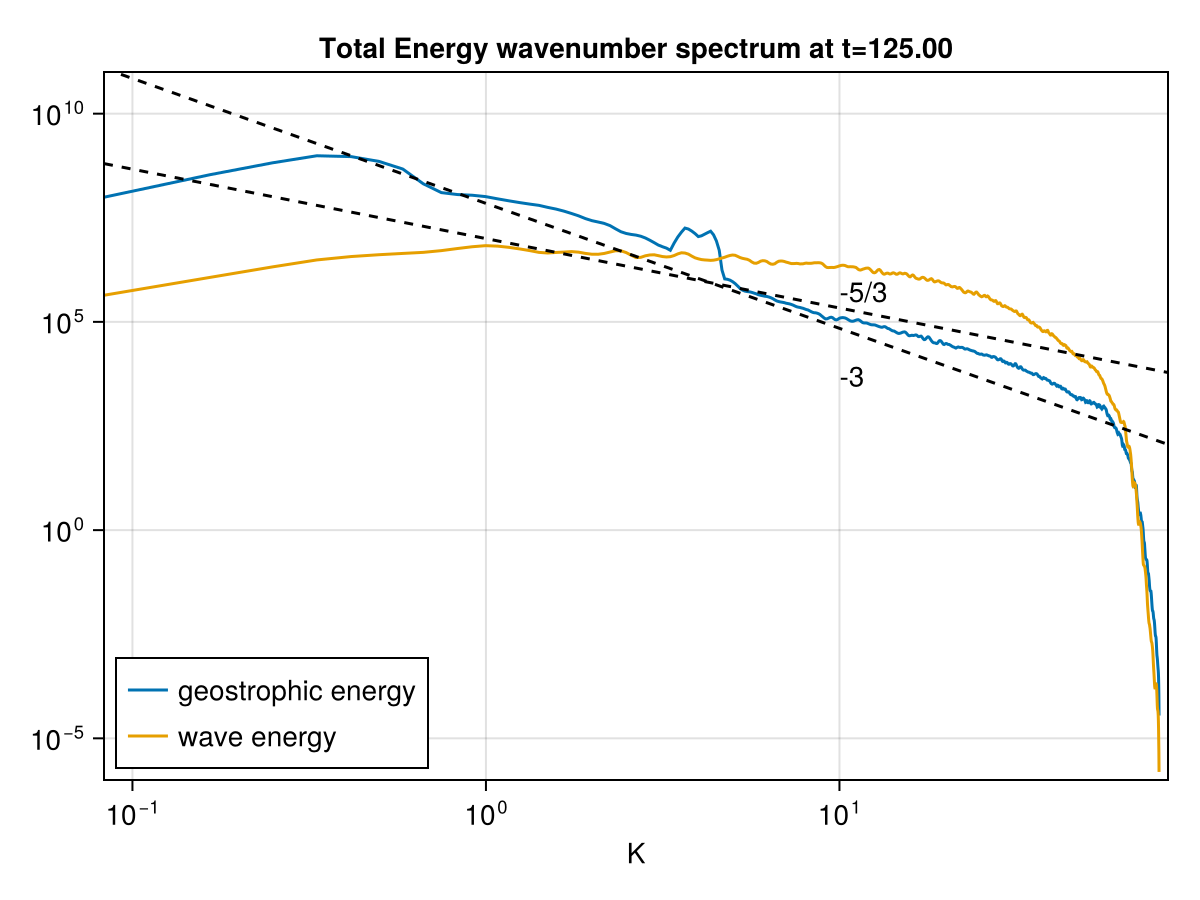

In [6]:
using FourierFlows: radialspectrum
#snapshot = snap_file["snapshots/sol/500100"]
snapshot = test_file["snapshots/sol/24999"]
Gh, Wh = decompose_balanced_wave(snapshot, grid)
ut =  grid.l .* snapshot[:,:,1] .* grid.invKrsq
vt = -grid.kr .* snapshot[:,:,1] .* grid.invKrsq

x, geostrophic_KE = radialspectrum(abs2.(Gh[:,:,1] + ut) + abs2.(Gh[:,:,2] + vt), grid)# + abs2.(ut) + abs2.(vt), grid)
x, wave_KE = radialspectrum(abs2.(Wh[:,:,1]) + abs2.(Wh[:,:,2]), grid)
x, test = radialspectrum(ones(grid.nkr, grid.nl), grid)

f = Figure()
ax = Axis(f[1,1]; xscale=log10, yscale=log10, 
    title=@sprintf("Total Energy wavenumber spectrum at t=%0.2f", test_file["snapshots/t/24999"]), xlabel="K", limits=((x[2], x[end]), (1e-6, 1e11)))

lines!(ax, x, geostrophic_KE[:], label="geostrophic energy")
lines!(ax, x, wave_KE[:], label="wave energy")
#lines!(ax, x, test[:], label=L"f_h=1")


lines!(ax, x, 1e7*x.^(-5/3), color="black", linestyle=:dash)
text!(ax, 10, 1e7*10^(-5/3), text="-5/3")

lines!(ax, x, 7e7*x.^(-3.00), color="black", linestyle=:dash)
text!(ax, 10, 2e6*10^(-3.00), text="-3")

#lines!(ax, x, 2*pi*x.^(1.00), color="black", linestyle=:dash)
#text!(ax, 40, 2*pi*50^(1.00), text="2πK")

axislegend(ax, position=:lb)
f

In [42]:
x

0.0:0.08308895405669599:85.0

In [7]:
N = 0
file_N = 249
grid = TwoDGrid(; nx=512, Lx=6π)
for file_idx=0:file_N
    file = jldopen(@sprintf("/vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.%08d.jld2", file_idx))
    N += length(keys(file["snapshots/sol"]))
    close(file)
end

snap_size=4
x_idx = [6, 117]
y_idx = [70, 231]
k_idx = [10, 20]
l_idx = [10, 20]
t = zeros(N)
ug = zeros(Float64, N, snap_size)
vg = zeros(Float64, N, snap_size)
uw = zeros(Float64, N, snap_size)
vw = zeros(Float64, N, snap_size)
uhg = zeros(Complex{Float64}, N, snap_size)
vhg = zeros(Complex{Float64}, N, snap_size)
uhw = zeros(Complex{Float64}, N, snap_size)
vhw = zeros(Complex{Float64}, N, snap_size)

base_index = 0
phi_geo = compute_balanced_basis(grid)
phi_plus, phi_minus = compute_wave_bases(grid)
decomp_bases = (phi_geo, phi_plus, phi_minus)
for file_idx=0:file_N
    filename = @sprintf("/vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.%08d.jld2", file_idx)
    println("Reading " * filename)
    file = jldopen(filename)
    snap_idxs = keys(file["snapshots/sol"])
    for i=1:length(snap_idxs)
        t[base_index + i]    = file["snapshots/t/" * snap_idxs[i]]
        snapshot = file["snapshots/sol/" * snap_idxs[i]]
        uth = grid.l .* grid.invKrsq .* snapshot[:,:,1]
        vth = -grid.kr .* grid.invKrsq .* snapshot[:,:,1]
        Gh, Wh = decompose_balanced_wave(snapshot, grid, decomp_bases)
        real_ut = irfft(uth, grid.nx, (1, 2))
        real_vt = irfft(vth, grid.nx, (1, 2))
        real_geo = irfft(Gh, grid.nx, (1, 2))
        real_wave = irfft(Wh, grid.nx, (1, 2))
        
        uhg[base_index + i,:] = Gh[k_idx, l_idx, 1] + uth[k_idx, l_idx]
        uhg[base_index + i,:] = Gh[k_idx, l_idx, 2] + vth[k_idx, l_idx]
        uhw[base_index + i,:] = Wh[k_idx, l_idx, 1]
        uhw[base_index + i,:] = Wh[k_idx, l_idx, 2]
        
        ug[base_index + i,:]  = real_geo[x_idx, y_idx, 1] + real_ut[x_idx, y_idx]
        vg[base_index + i,:]  = real_geo[x_idx, y_idx, 2] + real_vt[x_idx, y_idx]
        uw[base_index + i,:]  = real_wave[x_idx, y_idx, 1]
        vw[base_index + i,:]  = real_wave[x_idx, y_idx, 2]

        #bt_ke[base_index + i] = parsevalsum2(uth, grid) + parsevalsum2(vth, grid)
        #ge_ke[base_index + i] = parsevalsum2(Gh[:,:,1], grid) + parsevalsum2(Gh[:,:,2], grid)
        #ge_pe[base_index + i] = parsevalsum2(Gh[:,:,3], grid)
        #wa_ke[base_index + i] = parsevalsum2(Wh[:,:,1], grid) + parsevalsum2(Wh[:,:,2], grid)
        #wa_pe[base_index + i] = parsevalsum2(Wh[:,:,3], grid)
    end
    base_index += length(snap_idxs)
    close(file)
end

Reading /vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000000.jld2
Reading /vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000001.jld2
Reading /vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000002.jld2
Reading /vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000003.jld2
Reading /vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000004.jld2
Reading /vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000005.jld2
Reading /vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000006.jld2
Reading /vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000007.jld2
Reading /vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000008.jld2
Reading /vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000009.jld2
Reading /vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000010.jld2
Reading /vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000011.jld2
Reading /vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000012.jld2

In [7]:
file_N = 250
grid = TwoDGrid(; nx=512, Lx=6π)

bt_ke = zeros(file_N+1)
ge_ke = zeros(file_N+1)
ge_pe = zeros(file_N+1)
wa_ke = zeros(file_N+1)
wa_pe = zeros(file_N+1)

te = zeros(file_N+1)

phi_geo = compute_balanced_basis(grid)
phi_plus, phi_minus = compute_wave_bases(grid)
decomp_bases = (phi_geo, phi_plus, phi_minus)
for file_idx=0:file_N
    array_idx = file_idx + 1
    filename = @sprintf("/vast/nad9961/thomasyamada_simulation/48950250/ty.jld2.%08d.jld2", file_idx)
    if(file_idx % 10 == 0)
        println("Reading " * filename)
    end
    file = jldopen(filename)
    snap_idx = keys(file["snapshots/sol"])[1]
    te[array_idx] = file["snapshots/t/" * snap_idx]
    snapshot = file["snapshots/sol/" * snap_idx]
    uth = grid.l .* grid.invKrsq .* snapshot[:,:,1]
    vth = -grid.kr .* grid.invKrsq .* snapshot[:,:,1]
    Gh, Wh = decompose_balanced_wave(snapshot, grid, decomp_bases)
    bt_ke[array_idx] = parsevalsum2(uth, grid) + parsevalsum2(vth, grid)
    ge_ke[array_idx] = parsevalsum2(Gh[:,:,1], grid) + parsevalsum2(Gh[:,:,2], grid)
    ge_pe[array_idx] = parsevalsum2(Gh[:,:,3], grid)
    wa_ke[array_idx] = parsevalsum2(Wh[:,:,1], grid) + parsevalsum2(Wh[:,:,2], grid)
    wa_pe[array_idx] = parsevalsum2(Wh[:,:,3], grid)
    close(file)
end

Reading /vast/nad9961/thomasyamada_simulation/48950250/ty.jld2.00000000.jld2
Reading /vast/nad9961/thomasyamada_simulation/48950250/ty.jld2.00000010.jld2
Reading /vast/nad9961/thomasyamada_simulation/48950250/ty.jld2.00000020.jld2
Reading /vast/nad9961/thomasyamada_simulation/48950250/ty.jld2.00000030.jld2
Reading /vast/nad9961/thomasyamada_simulation/48950250/ty.jld2.00000040.jld2
Reading /vast/nad9961/thomasyamada_simulation/48950250/ty.jld2.00000050.jld2
Reading /vast/nad9961/thomasyamada_simulation/48950250/ty.jld2.00000060.jld2
Reading /vast/nad9961/thomasyamada_simulation/48950250/ty.jld2.00000070.jld2
Reading /vast/nad9961/thomasyamada_simulation/48950250/ty.jld2.00000080.jld2
Reading /vast/nad9961/thomasyamada_simulation/48950250/ty.jld2.00000090.jld2
Reading /vast/nad9961/thomasyamada_simulation/48950250/ty.jld2.00000100.jld2
Reading /vast/nad9961/thomasyamada_simulation/48950250/ty.jld2.00000110.jld2
Reading /vast/nad9961/thomasyamada_simulation/48950250/ty.jld2.00000120.jld2

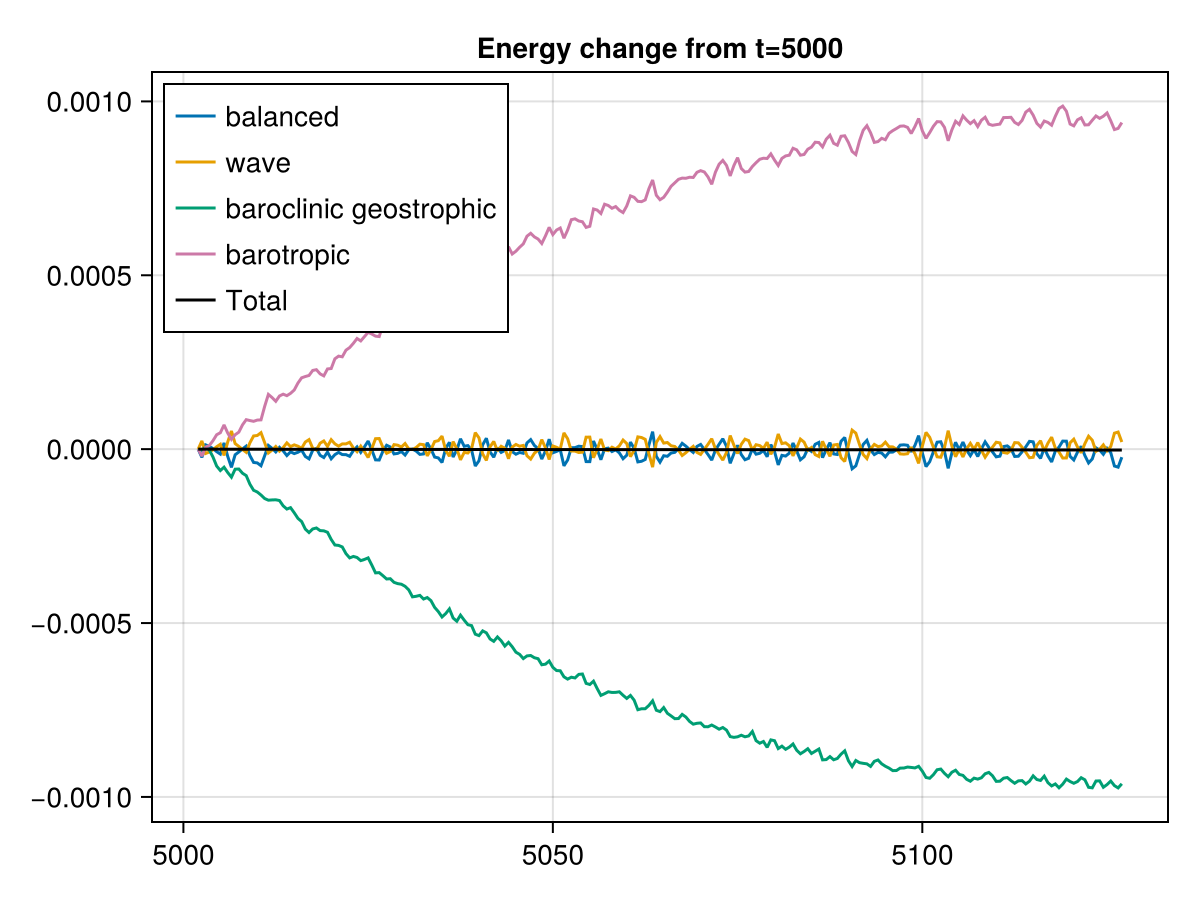

In [29]:
f = Figure()
ax = Axis(f[1,1], title = "Energy change from t=5000")
balanced = bt_ke + ge_ke + ge_pe
wave = wa_ke + wa_pe
geo = ge_ke + ge_pe
tro = bt_ke
total = wave + balanced
lines!(ax, te, balanced .- (balanced)[1], label="balanced")
lines!(ax, te, wave .- wave[1], label="wave")
lines!(ax, te, geo .- geo[1], label="baroclinic geostrophic")
lines!(ax, te, tro .- tro[1], label="barotropic")
lines!(ax, te, total .- total[1], label="Total", color="black")

axislegend(ax, position=:lt)
f

In [8]:
function demean(data)
    mean = sum(data, dims=1) / size(data, 1)
    return data .- mean
end

function linear_least_squares(t, data)
    tsum = sum(t)
    t2sum = sum(t.^2)
    txsum = sum(t .* data, dims=1)
    N = size(t,1)
    slope = (N * (txsum)) / (N * t2sum - tsum.^2)
    intercept = -slope * tsum / N
    return (slope, intercept)
end

function detrend(t, data)
    m, b = linear_least_squares(t, demean(data))
    return data .- m .* t .- b
end
#vc = vc[1:base_index,:]
#t = t[1:base_index]
#vc_demean = demean(vc)
#vc_detrend = detrend(t, vc_demean)

#vg = vc - vw
t = t[1:base_index]

ug = ug[1:base_index,:]
ug_demean = demean(ug)
ug_detrend = detrend(t, ug_demean)

Ugh = detrend(t, demean((uhg + 1im * vhg)[1:base_index,:]))
Uwh = detrend(t, demean((uhw + 1im * vhw)[1:base_index,:]))
Ug = detrend(t, demean((ug + 1im * vg)[1:base_index,:]))
Uw = detrend(t, demean((uw + 1im * vw)[1:base_index,:]))

vg = vg[1:base_index,:]
vg_demean = demean(vg)
vg_detrend = detrend(t, vg_demean)

uw = uw[1:base_index,:]
uw_demean = demean(uw)
uw_detrend = detrend(t, uw_demean)

vw = vw[1:base_index,:]
vw_demean = demean(vw)
vw_detrend = detrend(t, vw_demean)

25000×4 Matrix{Float64}:
 -0.0608255   -0.0723438   0.0165895     0.0177518
 -0.0561297   -0.0734102   0.0145602     0.0224981
 -0.0509156   -0.0745503   0.0122337     0.0273166
 -0.0452354   -0.0757712   0.00964536    0.0321663
 -0.0391498   -0.077081    0.00683146    0.0370049
 -0.032726    -0.0784884   0.00382853    0.0417893
 -0.0260362   -0.0800023   0.000673024   0.0464771
 -0.0191559   -0.0816306  -0.00259885    0.0510267
 -0.0121622   -0.0833797  -0.00595115    0.0553987
 -0.0051323   -0.0852535  -0.00934808    0.0595571
  0.00185828  -0.0872524  -0.0127538     0.0634704
  0.00873673  -0.0893728  -0.0161323     0.0671123
  0.0154342   -0.0916061  -0.0194469     0.0704634
  ⋮                                     
 -0.0403689   -0.0817915  -0.00929809   -0.0226535
 -0.0373766   -0.0809915  -0.0107459    -0.0272773
 -0.0343704   -0.0798255  -0.0123104    -0.0321338
 -0.0314123   -0.0783028  -0.0139523    -0.037175
 -0.0285641   -0.0764412  -0.0156265    -0.042346
 -0.0258848   -0.0

In [22]:
Nstar = base_index
N_half = Int(base_index/2 + 2)
series_g = ug + 1im*vg
# series_w = uw[2:end,:] - uw[1:end-1,:] + 1im* (vw[2:end,:] - vw[1:end-1,:])
series_w = uw + 1im * vw
#series_g = vg[2:end,:] - vg[1:end-1,:]
signal_g  = fft(hamm(Nstar) .* Ug,1)
signal_w  = fft(hamm(Nstar) .* Uw,1)
signal_T = fft(hamm(Nstar) .* (Uw + Ug), 1)
signal_wh = fft(hann(Nstar) .* Uwh,1)
signal_gh = fft(hann(Nstar) .* Ugh,1)
signal_Th = fft(hann(Nstar) .* (Uwh + Ugh), 1)
dt = t[2] - t[1]
ω = fftshift(fftfreq(Nstar, 1/(dt))) * 2*pi
T = Nstar * dt
Rayleigh_ω = 2*π / T
Nyquist_ω = π / dt

628.3185307179588

In [42]:
ω[1:N_half-2]
ω[N_half:end]

0.050265482457407445:0.0502654824574367:628.2682652355013

[4.358898943540674, 7.0789201938651, 7.0789201938651, 9.012337223063849]


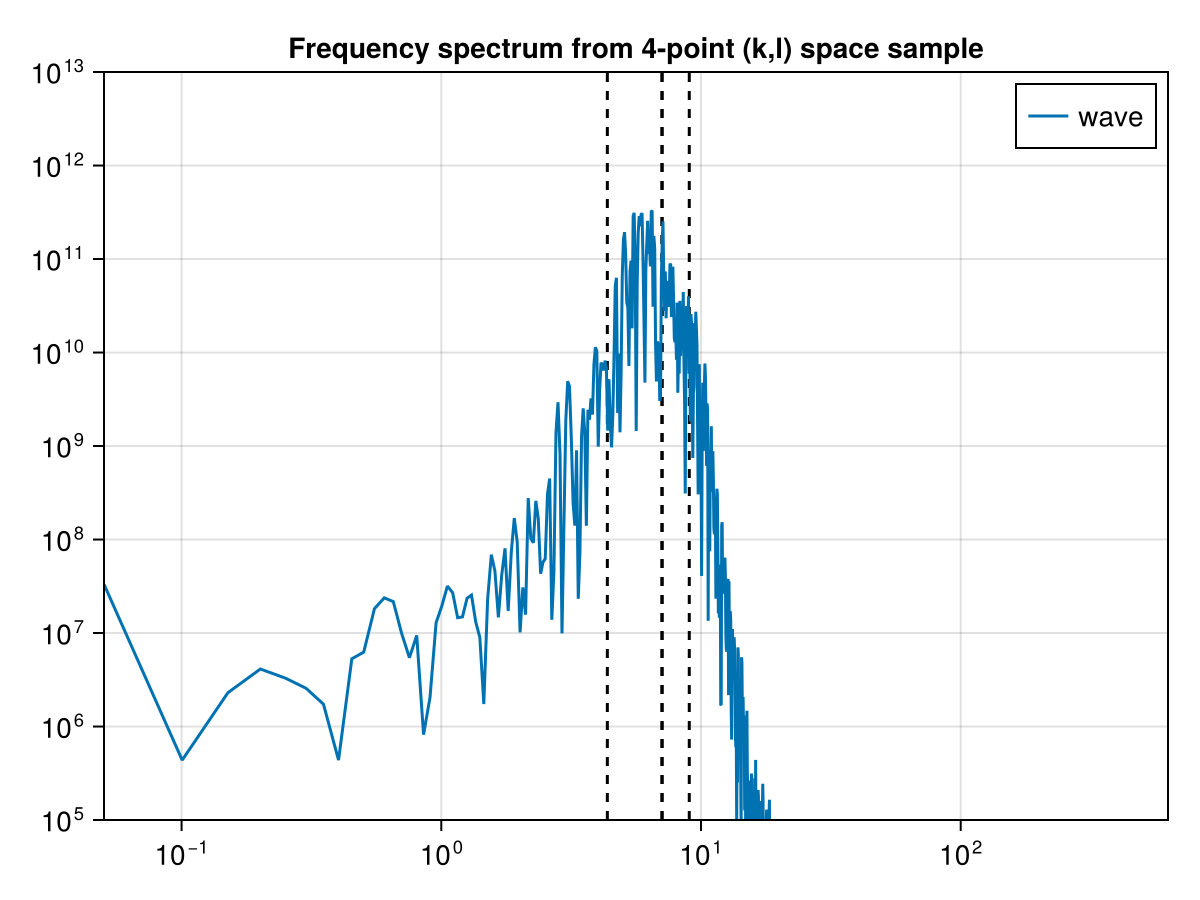

In [51]:
#plot(ω, fftshift(atan.(imag(signal), real(signal))))
f = Figure()
ax = Axis(f[1,1]; xscale=log10, yscale=log10, title="Frequency spectrum from 4-point (k,l) space sample", 
    limits=((Rayleigh_ω, Nyquist_ω), (1e5, 1e13)));
my_K = sqrt.(1 .+ grid.kr[k_idx].^2 .+ (grid.l[l_idx]').^2)[:]
println(my_K)
for i=1:4
    lines!(ax, my_K[i] .+ [0, 0], [1e5, 1e13], linestyle=:dash, color="black")
end
#lines!(ax, ω[N_half:end], sum(fftshift(abs2.(signal_g))[N_half:end, :], dims=2)[:,1]/4, label="balanced")
#lines!(ax, ω[N_half:end], sum(fftshift(abs2.(signal_Th))[N_half:end, :] + fftshift(abs2.(signal_Th))[(N_half-2):-1:2, :], dims=2)[:,1], label="wave")
lines!(ax, ω[N_half:end], fftshift(abs2.(signal_wh))[N_half:end, 1], label="wave")
#lines!(ax, ω[N_half:end], sum(fftshift(abs2.(signal_T))[N_half:end, :], dims=2)[:,1]/4, label="total")

#lines!(ax, -ω[N_half-3:-1:1], fftshift(abs2.(signal_c))[N_half-3:-1:1, i])
#lines!(ax, -ω[N_half-3:-1:1], fftshift(abs2.(signal_w))[N_half-3:-1:1, i], label="anti-inertial")
#lines!(ax, -ω[N_half-3:-1:1], fftshift(abs2.(signal_g))[N_half-3:-1:1, i])
#lines!(ax, ω[N_half:end], 1e3*ω[N_half:end].^(-0.00), label="0.00", color="black", linestyle=:dot)
#lines!(ax, ω[N_half:end], 2e2*ω[N_half:end].^(-2.00), label="-2.00", color="black", linestyle=:dash)
axislegend(ax)
f

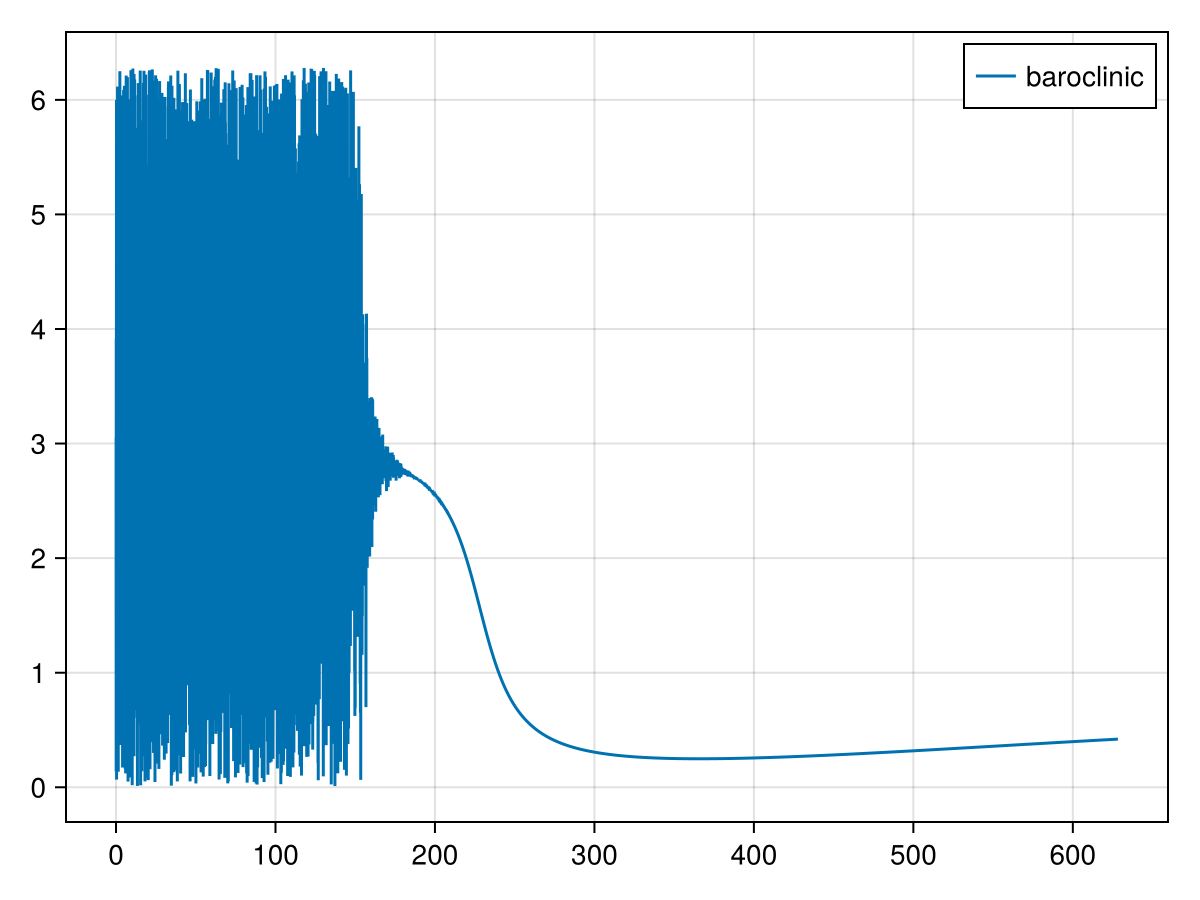

In [22]:
f = Figure()
ax = Axis(f[1,1]);

for i=1:1
    phase = atan.(imag(signal_g[:,i]), real(signal_g[:,i]))
    phase[phase .<= 0] .+= 2*π
    lines!(ax, ω[N_half:end], fftshift(phase)[N_half:end], label="baroclinic")

    #phase = atan.(imag(signal_g[:,i]), real(signal_g[:,i]))
    #phase[phase .<= 0] .+= 2*π
    #lines!(ax, ω[N_half:end], fftshift(phase)[N_half:end], label="geostrophic")

    #phase = atan.(imag(signal_w[:,i]), real(signal_w[:,i]))
    #phase[phase .<= 0] .+= 2*π
    #lines!(ax, ω[N_half:end], fftshift(phase)[N_half:end], label="wave")
end

axislegend(ax)
f

In [12]:
lines(real.(series))

LoadError: MethodError: no method matching real(::typeof(series))

[0mClosest candidates are:
[0m  real([91m::LinearAlgebra.Symmetric{var"#s972", S} where {var"#s972"<:Real, S<:(AbstractMatrix{<:var"#s972"})}[39m)
[0m[90m   @[39m [35mLinearAlgebra[39m [90m/ext3/julia-1.9.4/share/julia/stdlib/v1.9/LinearAlgebra/src/[39m[90m[4msymmetric.jl:355[24m[39m
[0m  real([91m::LinearAlgebra.Symmetric[39m)
[0m[90m   @[39m [35mLinearAlgebra[39m [90m/ext3/julia-1.9.4/share/julia/stdlib/v1.9/LinearAlgebra/src/[39m[90m[4msymmetric.jl:357[24m[39m
[0m  real([91m::LinearAlgebra.Diagonal[39m)
[0m[90m   @[39m [35mLinearAlgebra[39m [90m/ext3/julia-1.9.4/share/julia/stdlib/v1.9/LinearAlgebra/src/[39m[90m[4mdiagonal.jl:151[24m[39m
[0m  ...


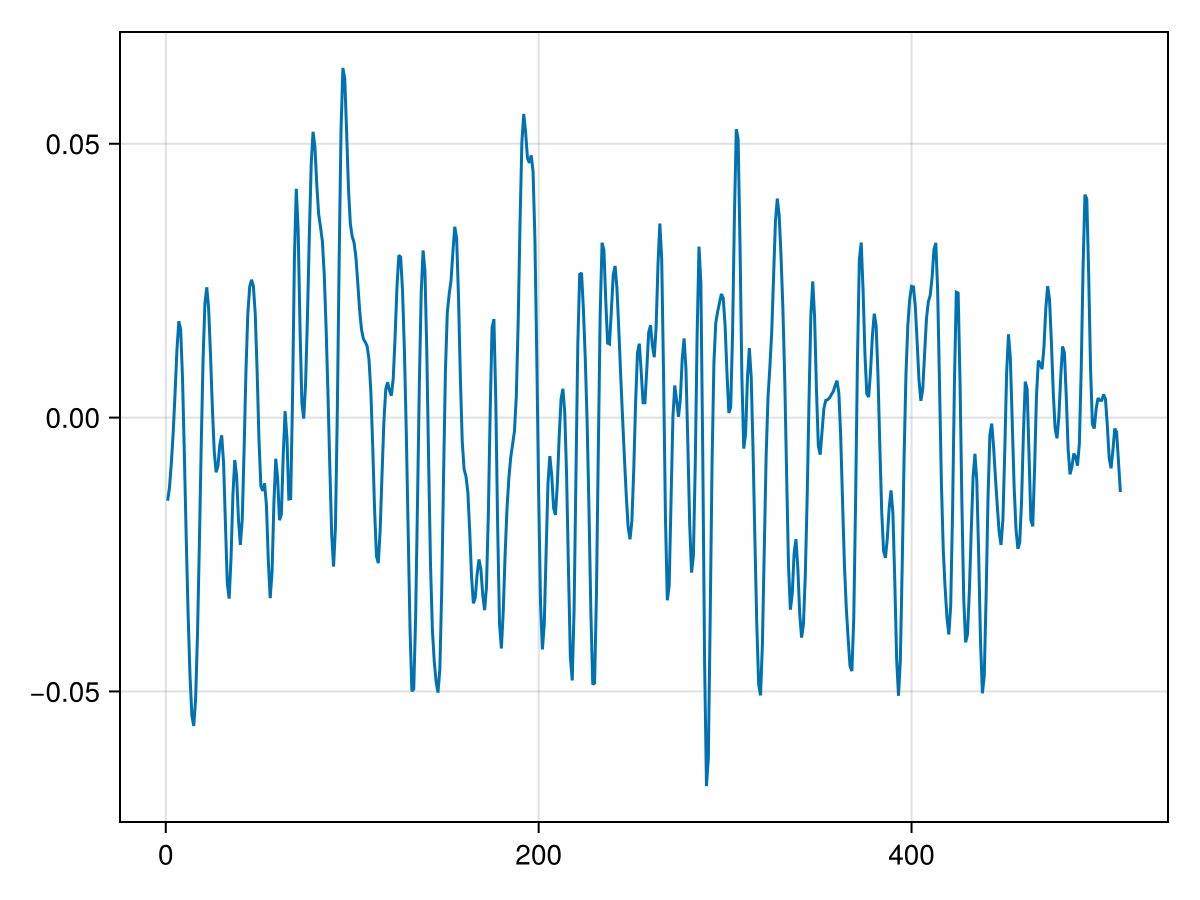

In [42]:
datafile = jldopen("/home/nad9961/JuliaRaytracingSW/data/thomasyamada_data/long-run4/ty.jld2.00000112.jld2")
#heatmap(irfft(datafile["snapshots/sol/11200"][:,:,2], 512); colormap=:balance)

ryans_data = datafile["snapshots/sol/11200"][:,75,2]
#plot(atan.(imag(ryans_data), real(ryans_data)))
lines(real(irfft(ryans_data, 512)))

3.656406807431622e11
0.0002006563027690433


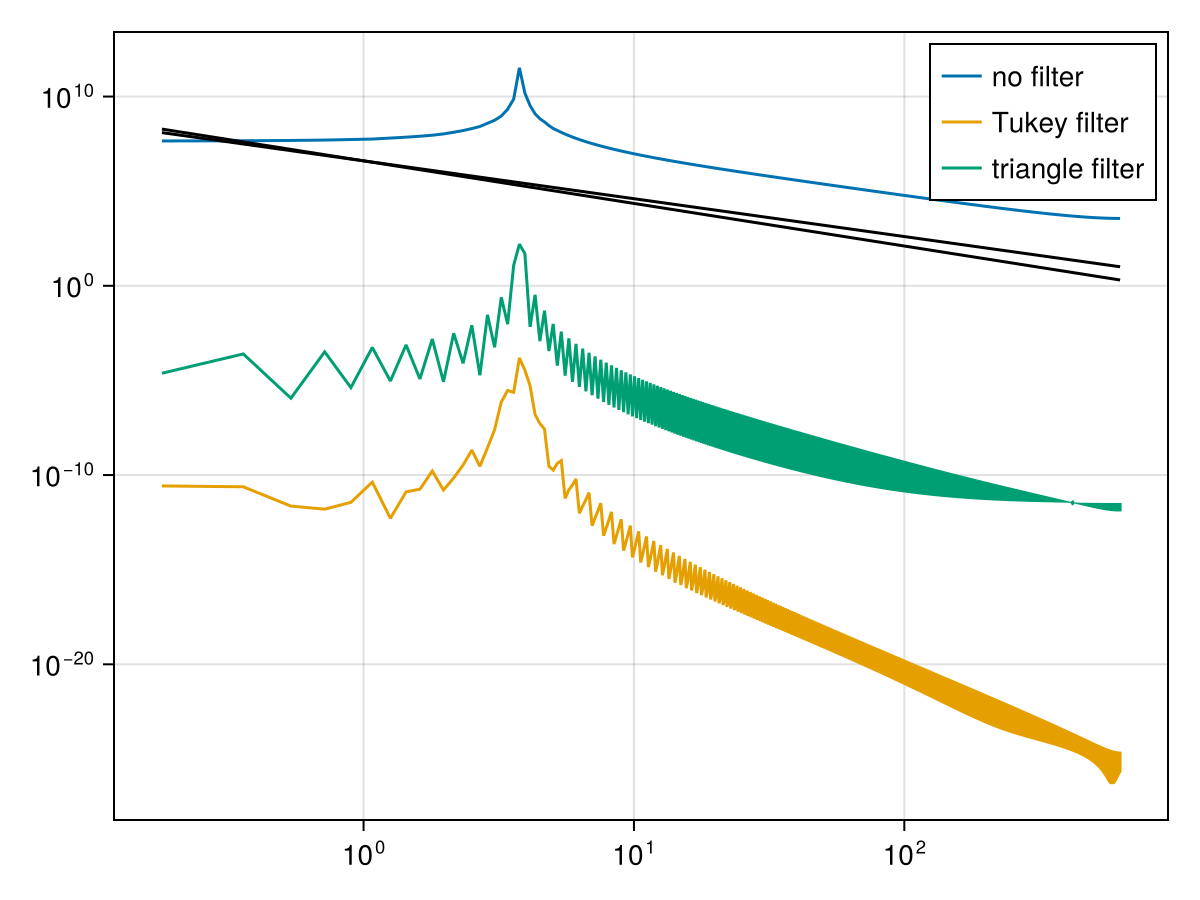

In [232]:
fig = Figure()
ax = Axis(fig[1,1], xscale=log10, yscale=log10)

N_half = Int(N/2)
window = hann(N)
dt = t[2] - t[1]
ω = fftshift(fftfreq(N, 1/dt)) * 2*pi
#lines!(ax, -ω[1:N_half], fftshift(abs2.(fft(og_vc .* hann(N))))[1:N_half])
#lines!(ax, -ω[1:N_half], fftshift(abs2.(fft(vc .* hann(N))))[1:N_half])
padded_vc = zeros(Complex{Float64}, N * 2, 10)
padded_vc[1:N, :] = vc

norm = sqrt(sum(abs2.(vc)))
data1 = fftshift(abs2.(fft(vc               , 1)), 1)[N_half+2:end,1]
data2 = fftshift(abs2.(fft(vc/norm .* tukey(N, 0.5), 1)), 1)[N_half+2:end,1] / sum(flattopw(N))^2
data3 = fftshift(abs2.(fft(vc/norm .* triangle(N)    , 1)), 1)[N_half+2:end,1]
#data2 = fftshift(abs2.(fft(vc .* box(N) , 1)), 1)[N_half+2:end,1]
#data3 = abs2.(fft(padded_vc, 1))[1:N_half,1]
#data4 = abs2.(fft(padded_vc .* hann(2*N), 1))[1:N_half,1]
println(sum(data1))
println(sum(data2))
lines!(ax, ω[N_half+2:end], data1, label="no filter")
lines!(ax, ω[N_half+2:end], data2, label="Tukey filter")
lines!(ax, ω[N_half+2:end], data3, label="triangle filter")
lines!(ax, ω[N_half+2:end], 4e6 * ω[N_half+2:end].^(-2); color="black") 
lines!(ax, ω[N_half+2:end], 4e6 * ω[N_half+2:end].^(-2.25); color="black")
axislegend(ax)
#lines!(ax, data2)
#lines!(ax, data3)
#lines!(ax, data4)

fig

In [135]:
ω

-628.3185307042438:1.2566370614084874:627.0618936428352

In [57]:
N_half = Int((N-1)/2)
ω[N_half+2]

0.050195209163506664

In [79]:
fftfreq(N, 1/dt)

1000-element Frequencies{Float64}:
  0.0
  0.19999999999563442
  0.39999999999126884
  0.5999999999869032
  0.7999999999825377
  0.9999999999781721
  1.1999999999738065
  1.399999999969441
  1.5999999999650754
  1.7999999999607097
  1.9999999999563443
  2.1999999999519786
  2.399999999947613
  ⋮
 -2.399999999947613
 -2.1999999999519786
 -1.9999999999563443
 -1.7999999999607097
 -1.5999999999650754
 -1.399999999969441
 -1.1999999999738065
 -0.9999999999781721
 -0.7999999999825377
 -0.5999999999869032
 -0.39999999999126884
 -0.19999999999563442

In [34]:
using FourierFlows
using LinearAlgebra: ldiv!, mul!

grid = TwoDGrid(;Lx=2π, nx=512, T=Float32)
dev = typeof(grid.device)
Kg = (10.f0, 13.f0)
Kw = (0.f0, 5.f0)
f = 3.f0
Cg2 = 1.f0
ag = 0.1
aw = 0.3

@devzeros dev Complex{Float32} (grid.nkr, grid.nl) ugh vgh ηgh uwh vwh ηwh
@devzeros dev Float32 (grid.nx, grid.ny) ug uw

geo_filter  = Kg[1]^2 .<= grid.Krsq .<= Kg[2]^2
wave_filter = Kw[1]^2 .<= grid.Krsq .<= Kw[2]^2
phase = device_array(grid.device)(2π*rand(grid.nkr, grid.nl))
sgn =  device_array(grid.device)(sign.(rand(grid.nkr, grid.nl) .- 0.5))
shift = exp.(1im * phase)
ηgh[geo_filter] += ( 0.5   * shift)[geo_filter]
ugh[geo_filter] += (-0.5im * Cg2 * f * grid.l  .* shift)[geo_filter]
vgh[geo_filter] += ( 0.5im * Cg2 * f * grid.kr .* shift)[geo_filter]

ldiv!(ug, grid.rfftplan, deepcopy(ugh))
ηgh *= ag / maximum(abs.(ug))
ugh *= ag / maximum(abs.(ug))
vgh *= ag / maximum(abs.(ug))

ωK =  sgn .* sqrt.(f^2 .+ Cg2 * grid.Krsq)
ηwh[wave_filter] += (0.5 * shift)[wave_filter]
uwh[wave_filter] += (grid.invKrsq.*(0.5 * grid.kr .* ωK .* shift + 0.5im * f * grid.l  .* shift))[wave_filter]
vwh[wave_filter] += (grid.invKrsq.*(0.5 * grid.l .*  ωK .* shift - 0.5im * f * grid.kr .* shift))[wave_filter]

ldiv!(uw, grid.rfftplan, deepcopy(uwh))
ηwh *= aw / maximum(abs.(uw))
uwh *= aw / maximum(abs.(uw))
vwh *= aw / maximum(abs.(uw))

257×512 Matrix{ComplexF64}:
      0.0+0.0im      -2671.73+7426.67im  …   7607.62+2101.83im
 -7487.49-42.0722im  -5357.72+1562.57im     -2687.96+4890.98im
  1729.57+3320.34im  -3524.43+192.748im      2474.88+2516.68im
 -570.011+2429.91im  -1098.37+2241.19im     -1136.79-2221.95im
 -566.773-1784.04im  -1833.08+551.5im        -1905.8+179.574im
 -1092.92-1023.76im       0.0+0.0im      …       0.0+0.0im
      0.0+0.0im           0.0+0.0im              0.0+0.0im
      0.0+0.0im           0.0+0.0im              0.0+0.0im
      0.0+0.0im           0.0+0.0im              0.0+0.0im
      0.0+0.0im           0.0+0.0im              0.0+0.0im
      0.0+0.0im           0.0+0.0im      …       0.0+0.0im
      0.0+0.0im           0.0+0.0im              0.0+0.0im
      0.0+0.0im           0.0+0.0im              0.0+0.0im
         ⋮                               ⋱  
      0.0+0.0im           0.0+0.0im      …       0.0+0.0im
      0.0+0.0im           0.0+0.0im              0.0+0.0im
      0.0+0.0im       

In [44]:
qwh = 1im * grid.kr .* vwh - 1im * grid.l .* uwh - f * ηwh#
divgh = 1im * grid.kr .* ugh + 1im * grid.l .* vgh
println(maximum(abs2.(qwh[2:end,2:end])))

2.724896592222526e-7


In [48]:
ηwh

257×512 Matrix{ComplexF64}:
  1717.17-1811.27im  -844.874+2348.52im  …  -2405.74-664.657im
  14.0241-2495.83im   1308.19-2125.56im     -575.798-2428.54im
 -2213.56+1153.05im   1203.07-2186.77im     -2436.02+543.275im
 -2429.91-570.011im  -2495.84-11.6174im      2495.27-54.5833im
  2378.71-755.697im    272.89-2480.91im     -1187.26-2195.4im
  1706.27-1821.54im       0.0+0.0im      …       0.0+0.0im
      0.0+0.0im           0.0+0.0im              0.0+0.0im
      0.0+0.0im           0.0+0.0im              0.0+0.0im
      0.0+0.0im           0.0+0.0im              0.0+0.0im
      0.0+0.0im           0.0+0.0im              0.0+0.0im
      0.0+0.0im           0.0+0.0im      …       0.0+0.0im
      0.0+0.0im           0.0+0.0im              0.0+0.0im
      0.0+0.0im           0.0+0.0im              0.0+0.0im
         ⋮                               ⋱  
      0.0+0.0im           0.0+0.0im      …       0.0+0.0im
      0.0+0.0im           0.0+0.0im              0.0+0.0im
      0.0+0.0im        